# Empirical Data Inference
Infer evolutionary parameters from empirical data with the ensemble density estimators.

In [1]:
import torch
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from model.simulator import simulate
from utils import get_ensemble_predictions, calc_stats, sbi_post, get_mode_and_hdi, grab_short_sumstat, grab_long_sumstat, grab_man_sumstat
from model.params import readable_prior as prior 
from plotting import plot_from_post, set_plots_size_params, compare_posts, short_sumstats_plot, compare_posts_across_lines
set_plots_size_params(20)

In [2]:
rename_dict = {'mu': r'Mutation rate (U)', 'w_ada': r'Beneficial fitness effect ($w_{b}$)', 
               'w_syn': r'Syn fitness effect ($w_{s}$)', 
               'w_non_syn': r'Non-syn fitness effect ($w_{ns}$)', 'p_ada_non_syn': r'Beneficial non-syn probability ($p_{bns}$)',
               'p_ada_syn': r'Beneficial syn probability ($p_{bs}$)', 'p0_non_syn': r'Mean initial non-syn ($M_{ns}$)', 
               'p0_syn': r'Mean initial syn ($M_{s}$)',
               'w_penalty': r'Initial log-fitness correlation ($\delta$)', 'epistasis_boost': r'Epistasis effect ($\eta$)'}


In [3]:
def infer_and_plot(ensemble_path, input_data, man_sumstat, syn_prob, sumstats_to_simulate=10,
                   plot_hdi=True, plot_short_PPC=True, plot_long_PPC=True, plot_freqs=True, samples_per_model=200):
    post, stats = get_ensemble_predictions(ensemble_path, input_data, None, prior, samples_per_model=samples_per_model)
    print(stats[stats.model=='ensemble'])
    post = post.rename(columns=rename_dict)
    post = post[rename_dict.values()]
    simulated_data = plot_from_post(post, stats, man_sumstat, num_of_samples=sumstats_to_simulate, syn_prob=syn_prob,
                                    plot_hdi=plot_hdi, plot_short_PPC=plot_short_PPC, plot_freqs=plot_freqs,
                                    plot_long_PPC=plot_long_PPC)
    return post, stats, simulated_data


In [4]:
# EB=1 --> no epistasis!, 0<EB<1 --> weak negative, EB<0 --> sign epistasis!
# PP=0 --> P0 muts are neutral, PP=1 --> P0 muts are not as deleterious as the rest of the muts

In [5]:
loop_coding = {}
loop_coding_short = {}
loop_coding_man = {}

def grab_long(sumstat):
    return sumstat[:204]

def grab_short(sumstat):
    return sumstat[:6]

def grab_man(sumstat):
    return np.concatenate((sumstat[:6],sumstat[204:]))

line_replica = {1: 'A', 2: 'B', 3: 'C'}

for i in range(1,4):
    total_coding_sumstat = torch.load(join('data_analysis', f'line{i}_total_sumstat.pt'))
    loop_coding[line_replica[i]] = grab_long(total_coding_sumstat)
    loop_coding_man[line_replica[i]] = grab_man(total_coding_sumstat)
    loop_coding_short[line_replica[i]] = grab_short(total_coding_sumstat)

syn_prob = 0.278

In [6]:
def get_ensemble_path(errs, replica, sumstat_type):
    return join('density_estimators', f'{errs} error rate', 'ensembles', replica, sumstat_type)


# LR Inference

In [7]:
inf_LR = {}

In [8]:
errs = '5e-05'
sumstat_type = 'LR'
replica = 'A'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LR[replica] = infer_and_plot(ensemble_path, loop_coding[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.640000  -1.426124  1.123279    0.299631  -0.815792   
1            w_syn  0.909000   0.515023  1.007128    0.999971   0.785608   
2        w_non_syn  0.600000   0.213381  0.748881    0.926160   0.516286   
3            w_ada  1.611000   1.181455  0.910725    2.432627   1.443089   
4        p_ada_syn  0.000641   0.000002  1.211527    0.003921   0.000169   
5    p_ada_non_syn  0.008180   0.003063  0.764548    0.009991   0.006188   
6           p0_syn  0.533000   0.450342  0.723872    0.599882   0.512149   
7       p0_non_syn  0.785000   0.702432  0.624025    0.878432   0.757203   
8        w_penalty  0.049800   0.000144  0.975747    1.254580   0.009334   
9  epistasis_boost  0.460000  -0.908896  0.844522    1.723327  -0.035377   

   hdi50_high     model  
0   -0.273429  ensemble  
1    0.959088  ensemble  
2    0.791022  ensemble  
3    1.827461  ensemble  
4    0.001417  ensemble  
5    0.

In [9]:
errs = '5e-05'
sumstat_type = 'LR'
replica = 'B'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LR[replica] = infer_and_plot(ensemble_path, loop_coding[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.621500  -1.876925  1.310404    0.148812  -1.055562   
1            w_syn  0.906000   0.467473  0.982408    0.999862   0.812848   
2        w_non_syn  0.610000   0.246449  0.746849    0.971860   0.585808   
3            w_ada  1.611000   1.127236  0.880915    2.469238   1.452261   
4        p_ada_syn  0.001695   0.000002  0.902905    0.005757   0.000887   
5    p_ada_non_syn  0.007350   0.002437  0.705918    0.009998   0.004838   
6           p0_syn  0.533000   0.446580  0.705306    0.599686   0.494146   
7       p0_non_syn  0.769000   0.700409  0.690952    0.856719   0.733261   
8        w_penalty  0.029950   0.000004  0.974349    1.295601   0.000031   
9  epistasis_boost -0.260000  -0.999628  0.859591    1.432425  -0.406155   

   hdi50_high     model  
0   -0.441807  ensemble  
1    0.984980  ensemble  
2    0.859210  ensemble  
3    1.842685  ensemble  
4    0.002965  ensemble  
5    0.

In [10]:
errs = '5e-05'
sumstat_type = 'LR'
replica = 'C'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LR[replica] = infer_and_plot(ensemble_path, loop_coding[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param     mode     hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.99500 -2.057965e+00  1.836960   -0.062567  -1.382598   
1            w_syn  0.94600  4.587391e-01  1.003331    0.999962   0.834267   
2        w_non_syn  0.82700  2.771183e-01  0.774131    0.998922   0.680820   
3            w_ada  2.07200  1.489180e+00  0.890114    2.693767   1.770131   
4        p_ada_syn  0.00119  7.373063e-07  1.263081    0.003386   0.000543   
5    p_ada_non_syn  0.00745  2.747026e-03  0.727037    0.010000   0.005890   
6           p0_syn  0.55700  4.672091e-01  0.802583    0.599952   0.524449   
7       p0_non_syn  0.79700  7.076993e-01  0.633123    0.879845   0.748441   
8        w_penalty  0.03020  2.092182e-04  1.129116    1.111362   0.000241   
9  epistasis_boost  0.13700 -9.741274e-01  0.954866    1.048787  -0.334356   

   hdi50_high     model  
0   -0.731466  ensemble  
1    0.989558  ensemble  
2    0.922795  ensemble  
3    2.171740  ensemble  
4    0.0017

In [ ]:
rename_dict = {'mu': r'Mutation rate (U)', 'w_ada': r'Beneficial fitness effect ($w_{b}$)', 
               'w_syn': r'Syn fitness effect ($w_{s}$)', 
               'w_non_syn': r'Non-syn fitness effect ($w_{ns}$)', 'p_ada_non_syn': r'Beneficial non-syn probability ($p_{bns}$)',
               'p_ada_syn': r'Beneficial syn probability ($p_{bs}$)', 'p0_non_syn': r'Mean initial non-syn ($M_{ns}$)', 
               'p0_syn': r'Mean initial syn ($M_{s}$)',
               'w_penalty': r'Initial log-fitness correlation ($\delta$)', 'epistasis_boost': r'Epistasis effect ($\eta$)'}


In [12]:
def compare_posts(posts, title_suffix='', colors=None, alpha=0.7):
    fig, axes = plt.subplots(4, 3, figsize=(18,15), constrained_layout=True)
    ax_dict = {r'Mutation rate (U)': (1,1), r'Syn fitness effect ($w_{s}$)': (1,2), 
               r'Non-syn fitness effect ($w_{ns}$)': (1,0), 
               r'Mean initial syn ($M_{s}$)': (0,0), r'Mean initial non-syn ($M_{ns}$)': (0,2),  
               r'Beneficial fitness effect ($w_{b}$)': (3,0), r'Initial log-fitness correlation ($\delta$)': (3,2), 
               r'Epistasis effect ($\eta$)': (3,1), r'Beneficial syn probability ($p_{bs}$)': (2,2), 
               r'Beneficial non-syn probability ($p_{bns}$)': (2,0)}
    if not colors:
        colors = sns.color_palette(None)
    title = 'Marginal Posteriors'
    title += title_suffix
    fig.suptitle(title)
    legend = True
    for col_name, ax_index in ax_dict.items():
        ax = axes[ax_index]
        col = 'err' if 'Mutation' in col_name else 'rel_err'
        for i, (name, df) in enumerate(posts.items()):
            df[col_name].hist(bins=20, label=name if legend else '_nolegend', ax=ax, alpha=alpha, color=colors[i])
        ax.set_xlabel(col_name.replace('\n', ' '))
        ax.set_ylabel('Count')
        legend = False
    fig.delaxes(axes[(0,1)])
    fig.delaxes(axes[(2,1)])
    fig.legend(loc=(0.4,0.85))

def compare_posts_across_lines(outputs_dict, colors=None, alpha=0.7):
    if 'A' in outputs_dict.keys():
        compare_posts({line: output[0] for line, output in outputs_dict.items()}, 
                      colors=colors, alpha=alpha, title_suffix=' by Replica')
    else:
        lines_dict = {1:'A', 2:'B', 3:'C'}
        compare_posts({lines_dict[line]: output[0] for line, output in outputs_dict.items()}, 
                  colors=colors, alpha=alpha, title_suffix=' by Replica')


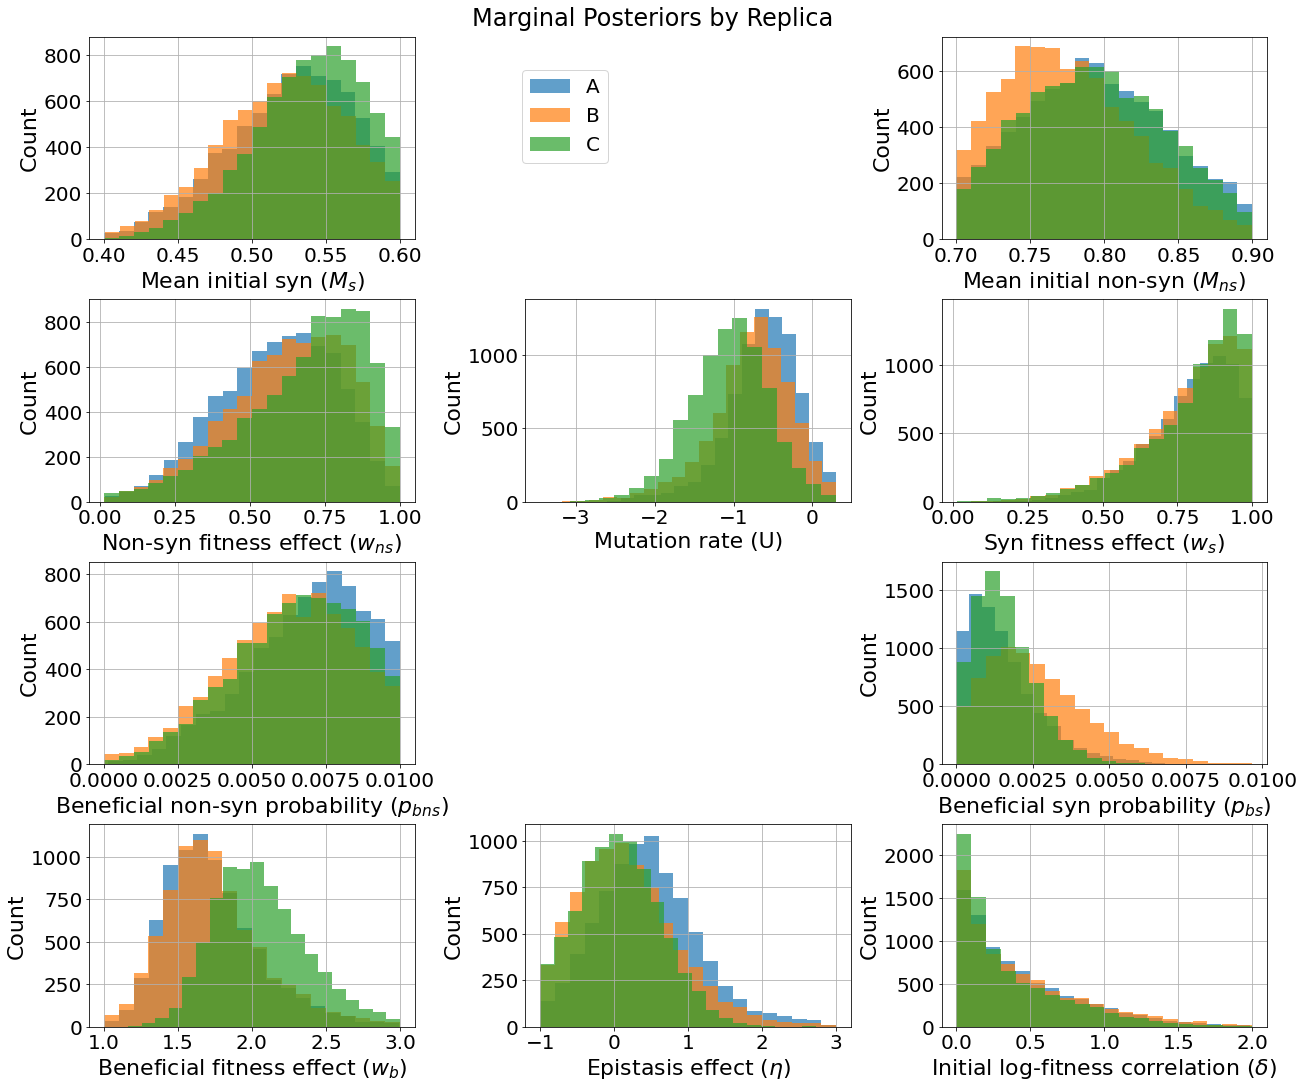

In [13]:
compare_posts_across_lines(inf_LR)

# L-LR Inference

In [ ]:
inf_LLR = {}

## Figure 6

In [ ]:
errs = '5e-05'
sumstat_type = 'L-LR'
replica = 'A'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=True, samples_per_model=1000, syn_prob=syn_prob)


In [ ]:
errs = '5e-05'
sumstat_type = 'L-LR'
replica = 'B'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


In [ ]:
errs = '5e-05'
sumstat_type = 'L-LR'
replica = 'C'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


In [ ]:
compare_posts_across_lines(inf_LLR)

# SR Inference

In [ ]:
inf_SR = {}

In [ ]:
errs = '5e-05'
sumstat_type = 'SR'
replica = 'A'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_SR[replica] = infer_and_plot(ensemble_path, loop_coding_short[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


In [ ]:
errs = '5e-05'
sumstat_type = 'SR'
replica = 'B'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_SR[replica] = infer_and_plot(ensemble_path, loop_coding_short[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


In [ ]:
errs = '5e-05'
sumstat_type = 'SR'
replica = 'C'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_SR[replica] = infer_and_plot(ensemble_path, loop_coding_short[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


In [ ]:
compare_posts_across_lines(inf_SR)

In [ ]:
all_posts = {'SR': pd.concat([x[0] for x in inf_SR.values()]),
             'LR': pd.concat([x[0] for x in inf_LR.values()]),
             'L-LR': pd.concat([x[0] for x in inf_LLR.values()])}
compare_posts(all_posts)

In [ ]:
def compare_posts_for_paper(posts, title_suffix='', colors=None, alpha=0.7, mu_xticks=(-3,1)):
    fig, axes = plt.subplots(3, 3, figsize=(18,15), constrained_layout=True)
    ax_dict = {'Mutation\nRate': (0,1), 'Syn\nEffect': (0,2), 'Non-Syn\nEffect': (0,0), 
               'Beneficial\nEffect': (2,0), 'P0 Penalty': (2,2), 
               'Epistasis\nFitness\nBoost': (2,1), 
               'Beneficial\nSyn\nProbability': (1,2), 'Beneficial\nNon-Syn\nProbability': (1,0)}
    if not colors:
        colors = sns.color_palette(None)
    title = 'Marginal Posteriors'
    title += title_suffix
    #fig.suptitle(title)
    legend = True
    for col_name, ax_index in ax_dict.items():
        ax = axes[ax_index]
        col = 'err' if 'Mutation' in col_name else 'rel_err'
        for i, (name, df) in enumerate(posts.items()):
            df[col_name].hist(bins=20, label=name if legend else '_nolegend', ax=ax, alpha=alpha, color=colors[i])
            if 'Mutation' in col_name:
                xticks = range(mu_xticks[0],mu_xticks[1])
                ax.set_xticks(xticks)
                ax.set_xticklabels([10**x for x in xticks])
            if 'Probability' in col_name:
                ax.set_xticks([0, 0.005, 0.01])
                #ax.set_xticklabels([10**x for x in xticks])
            if 'stasis' in col_name:
                ax.axvline(0.5, ls='--', color='k')    
        ax.set_xlabel(col_name.replace('\n', ' '))
        if 'Penalty' in col_name:
            ax.set_xlabel('P0 log-fitness Correlation')
        ax.set_ylabel('Count')
        legend = False
    fig.delaxes(axes[(1,1)])
    #fig.delaxes(axes[(2,1)])
    fig.legend(loc=(0.46,0.46))


## Fig 5B

In [ ]:
compare_posts_for_paper({'SR': all_posts['SR'], 'LR': all_posts['LR'], 'L-LR': all_posts['L-LR']})

## Table 1 + Table S2 data

In [ ]:
all_posts_tmp = {k :v.rename(columns={v:k for k,v in rename_dict.items()}) for k,v in all_posts.items()}
stats = {k : calc_stats(v, None, prior) for k,v in all_posts_tmp.items()}
for k, v in stats.items():
    for param in v.param.unique():
        print(k)
        print(param)
        print(v[v.param==param][['hdi95_low', 'mode', 'hdi95_high']])

## Fig 5A

This code block requires FITS posterior file (FITS_post.tsv) which can be download from [Zenodo](https://zenodo.org/record/7486851/files/FITS_post.tar.gz?download=1)


In [ ]:
def plot_post_estimates(ax):
    fits_post = pd.read_table('FITS/FITS_post.tsv')
    sample_size = 10000
    bin_num = 30
    alpha = 0.6
    fits_post.log_U.sample(sample_size).hist(bins=bin_num, label='FITS', density=True, color=sns.color_palette()[7])
    all_posts['SR']['Mutation\nRate'].sample(sample_size).hist(bins=bin_num, alpha=alpha, label='SR', 
                                                               density=True,ax=ax)
    all_posts['LR']['Mutation\nRate'].sample(sample_size).hist(bins=bin_num, alpha=alpha, label='LR', 
                                                               density=True, ax=ax)
    all_posts['L-LR']['Mutation\nRate'].sample(sample_size).hist(bins=bin_num, alpha=alpha, label='L-LR', 
                                                                 density=True, ax=ax)
    xticks = [-3,-2,-1,0, 1]
    ax.xticks(xticks, labels=[10**x for x in xticks])
    ax.yticks([0,0.5,1,1.5])
    stop_codon_estimate = np.log10(0.187)
    ax.axvline(stop_codon_estimate, ls='--', color='k', ymax=0.595)
    ax.axhline(1, xmax=0.579, ls='--', color='k')
    handles, labels = plt.gca().get_legend_handles_labels()
    line = plt.Line2D([0], [0], label='Stop Codons \n estimate', color='k', ls='--')
    handles.extend([line])
    ax.legend(handles=handles)


In [ ]:
def compare_posts_for_paper(posts, title_suffix='', colors=None, alpha=0.7, mu_xticks=(-3,1), legend_loc=(0.42,0.46)):
    mosaic = """
        AAA
        AAA
        BCD
        EFG
        """
    fig = plt.figure(constrained_layout=True, figsize=(16,12))
    ax_dict = fig.subplot_mosaic(mosaic)
    param_to_plot_dict = {'Mutation rate (U)': 'A', r'Syn fitness effect ($w_{s}$)': 'B',
                          r'Non-syn fitness effect ($w_{ns}$)': 'C', 
                          r'Beneficial syn probability ($p_{bs}$)': 'D', 
                          r'Beneficial fitness effect ($w_{b}$)': 'E', 
                          r'Epistasis effect ($\eta$)': 'F', 
                          r'Beneficial non-syn probability ($p_{bns}$)': 'G'}
    if not colors:
        colors = sns.color_palette(None)
    legend = True
    for col_name, ax_index in param_to_plot_dict.items():
        ax = ax_dict[ax_index]
        col = 'err' if 'Mutation' in col_name else 'rel_err'
        for i, (name, df) in enumerate(posts.items()):
            breakpoint()
            df[col_name].hist(bins=20, label=name if legend else '_nolegend', ax=ax, alpha=alpha, color=colors[i], density=True)
            if 'Mutation' in col_name:
                xticks = range(mu_xticks[0],mu_xticks[1])
                ax.set_xticks(xticks)
                ax.set_xticklabels([10**x for x in xticks])
            if 'Probability' in col_name:
                ax.set_xticks([0, 0.005, 0.01])
                #ax.set_xticklabels([10**x for x in xticks])
            if 'stasis' in col_name:
                ax.axvline(0.5, ls='--', color='k')    
        ax.set_xlabel(rename_dict_to_new[col_name])
        if 'Penalty' in col_name:
            ax.set_xlabel('P0 log-fitness Correlation')
        ax.set_ylabel('Density', size=25)
        legend = False
    fig.legend(loc=legend_loc, title='summary statistic')


In [ ]:
compare_posts_for_paper({'SR': all_posts['SR'], 'LR': all_posts['LR'], 'L-LR': all_posts['L-LR']})

# Large Errors (10x loop errs)

In [ ]:
large_errs_LLR = {}

In [ ]:
errs = '5e-04'
replica = 'A'
sumstat_type = 'L-LR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

In [ ]:
errs = '5e-04'
replica = 'B'
sumstat_type = 'L-LR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

In [ ]:
errs = '5e-04'
replica = 'C'
sumstat_type = 'L-LR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

In [ ]:
compare_posts_across_lines(large_errs_LLR)

## Fig S4

In [ ]:
man_errs = {'E-05 Seq Error rate': pd.concat([x[0] for x in inf_LLR.values()]),
            'E-04 Seq Error rate': pd.concat([x[0] for x in large_errs_LLR.values()])}
compare_posts_for_paper(man_errs, mu_xticks=(-2,1))

In [ ]:
replica = 'A'
compare_posts({'low': inf_LLR[replica][0], 'high': large_errs_LLR[replica][0]})

In [ ]:
replica = 'B'
compare_posts({'low': inf_LLR[replica][0], 'high': large_errs_LLR[replica][0]})

In [ ]:
replica = 'C'
compare_posts({'low': inf_LLR[replica][0], 'high': large_errs_LLR[replica][0]})